# 변종2

* KS통계량 값을 가중치로 학습시키기 
* 1  컬럼수만큼이 좋을지 
* 2  1이라는 수가 좋을지 
* magan 처럼 boundary 를 주는 방식으로

## > 학습이 잘 안된다.....
## > Hinge loss로 변경하기
## SNGAN https://github.com/isr-wang/SNGAN/blob/master/generator.py

In [1]:

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis
slim = tf.contrib.slim

from tensorflow.contrib.distributions import percentile as tf_percent



In [2]:
import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [3]:
data = pd.read_csv("./credit44_sc.csv" )

In [4]:
fac_var = []
num_var = []
for i in list(data) : 
    if data[i].nunique() < 15 : 
        print("factor variable : {}, count : {} ".format(i, data[i].nunique()))
        fac_var.append(i)
        if data[i].nunique() == 2 :
            print("binary" , i)
    else : 
        print("연속형 variable : {} , count : {} ".format(i, data[i].nunique()))
        num_var.append(i)
        
data = data.loc[:,fac_var + num_var]

col = list(data)

연속형 variable : SCORE_ORG , count : 395 
연속형 variable : SCORE_NK0200_000 , count : 445 
연속형 variable : SCORE_RK0400_700 , count : 294 
factor variable : CNT_CONTACT_POS, count : 8 
factor variable : CNT_ENG, count : 7 
factor variable : DAYS_CONTACT_POS, count : 11 
factor variable : DAYS_CALL_PAYMENT, count : 11 
factor variable : EWS_C_N_P27000100, count : 14 
연속형 variable : EWS_A_K_D1M232000_OPR , count : 2384 
factor variable : EWS_C_N_P42000200, count : 14 
연속형 variable : EWS_C_N_P32003000 , count : 31 
연속형 variable : AGE , count : 54 
연속형 variable : CNT_Contact , count : 29 
연속형 variable : EWS_A_K_D1M23200C_OPR , count : 2384 
연속형 variable : EWS_C_K_D10310000_OPR , count : 52 
연속형 variable : EWS_A_K_D90232200_OPR , count : 2490 
연속형 variable : D_N_CA0000603 , count : 4894 
연속형 variable : EWS_C_N_P32002600 , count : 22 
연속형 variable : EWS_D_N_P43004000 , count : 399 
factor variable : C_N_PS0001777, count : 11 
factor variable : A_K_D10220000_OPR, count : 9 
연속형 variable : SCORE_RK

In [5]:
# def plot(samples):
#     fig = plt.figure(figsize=(4, 4))
#     gs = gridspec.GridSpec(4, 4)
#     gs.update(wspace=0.05, hspace=0.05)

#     for i, sample in enumerate(samples):
#         ax = plt.subplot(gs[i])
#         plt.axis('off')
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
#         ax.set_aspect('equal')
#         plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

#     return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def log(x):
    return tf.log(x + 1e-8)


def spectral_norm(w, iteration=1 , name = None):
    w_shape = w.shape.as_list()
    w = tf.reshape(w, [-1, w_shape[-1]])
    
    u = tf.get_variable(name , [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)

    u_hat = u
    v_hat = None
    for i in range(iteration):
       
        """
       power iteration
       Usually iteration = 1 will be enough
       """
        
        v_ = tf.matmul(u_hat, tf.transpose(w))
        v_hat = tf.nn.l2_normalize(v_)

        u_ = tf.matmul(v_hat, w)
        u_hat = tf.nn.l2_normalize(u_)

    u_hat = tf.stop_gradient(u_hat)
    v_hat = tf.stop_gradient(v_hat)

    sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

    with tf.control_dependencies([u.assign(u_hat)]):
        w_norm = w / sigma
        w_norm = tf.reshape(w_norm, w_shape)

    return w_norm 

In [6]:
# tf.reset_default_graph()
# X = tf.placeholder(tf.float32, shape=[None, X_dim], name="X")
# D_W1 = tf.get_variable("DW1",[X_dim, h_dim], dtype=tf.float32)
# # spectral_norm(D_W1)
# D_b1 = tf.get_variable("DB1", [h_dim], dtype=tf.float32 , initializer=tf.constant_initializer(0.0))
# tf.nn.relu(tf.matmul(X, spectral_norm(D_W1)) + D_b1)

In [7]:
# tf.reset_default_graph()
# kernel , channels = 5, 3 
# x =X 
# stride =2 
# w = tf.get_variable("kernel", shape=[kernel, kernel, x.get_shape()[-1], channels])
# b = tf.get_variable("bias", [channels], initializer=tf.constant_initializer(0.0))

# x = tf.nn.conv2d(input=x, filter=spectral_norm(w), strides=[1, stride, stride, 1],padding ="SAME") + b

In [8]:
#D_h1 = tf.nn.relu(tf.matmul(X, spectral_norm(D_W1)) + D_b1)

In [9]:
mb_size = 1000
X_dim = np.shape(data)[1]
z_dim = 64
h_dim = 128
lr = 1e-4
d_steps = 3


mb_size = 32
X_dim = np.shape(data)[1]
z_dim = 64
h_dim = 128
lr = 1e-3
d_steps = 3

나쁘지 않게 나온다.

In [10]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, X_dim], name="X")
z = tf.placeholder(tf.float32, shape=[None, z_dim], name="z")
m = tf.placeholder(tf.float32 , name  = "KS")


def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

device = ['/gpu:3' , '/gpu:3']


def D(X,reuse=tf.AUTO_REUSE ):
    with tf.device(device[0]) :
        with tf.variable_scope( "Discriminator" ,reuse=reuse  ) as scope :
            D_W1 = tf.get_variable("DW1",[X_dim, h_dim], dtype=tf.float32)
            D_b1 = tf.get_variable("DB1", [h_dim], dtype=tf.float32 , initializer=tf.constant_initializer(0.0))
            D_W2 = tf.get_variable("DW2",[h_dim, h_dim], dtype=tf.float32)
            D_b2 = tf.get_variable("DB2",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            D_W3 = tf.get_variable("DW3",[h_dim, h_dim], dtype=tf.float32)
            D_b3 = tf.get_variable("DB3",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            D_W4 = tf.get_variable("DW4",[h_dim, 1], dtype=tf.float32)
            D_b4 = tf.get_variable("DB4",[1], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            
            
            D_h1 = tf.nn.leaky_relu(tf.matmul(X, spectral_norm(D_W1 , name ="sn1")) + D_b1)
            D_h2 = tf.nn.leaky_relu(tf.matmul(D_h1, spectral_norm(D_W2 , name ="sn2")) + D_b2)
            D_h3 = tf.nn.leaky_relu(tf.matmul(D_h2, spectral_norm(D_W3 , name ="sn3")) + D_b3)
            out = tf.matmul(D_h3, spectral_norm(D_W4, name ="sn4")) #+ D_b3
        return out


def G( Z = None , reuse = tf.AUTO_REUSE) : 
    with tf.device(device[1]) :
        with tf.variable_scope("Generator" , reuse = reuse) as scope: 
            G_W1 = tf.get_variable("GW1",[z_dim, h_dim], dtype=tf.float32 , initializer=tf.contrib.layers.xavier_initializer())
            G_b1 = tf.get_variable("GB1",[h_dim],dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W2 = tf.get_variable("GW2" ,[h_dim, h_dim], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
            G_b2 = tf.get_variable("GB2",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W3 = tf.get_variable("GW3" ,[h_dim, h_dim], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())
            G_b3 = tf.get_variable("GB3",[h_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            G_W4 = tf.get_variable("GW4" ,[h_dim, X_dim], dtype=tf.float32)
            G_b4 = tf.get_variable("GB4",[X_dim], dtype=tf.float32, initializer=tf.constant_initializer(0.0))
            
            G_h1 = tf.layers.dropout(tf.matmul(Z, G_W1) + G_b1)
            G_h1 = tf.contrib.layers.batch_norm(G_h1 )
            G_h1 = tf.nn.leaky_relu(G_h1)
            G_h2 = tf.layers.dropout(tf.matmul(G_h1, G_W2) + G_b2)
            G_h2 = tf.contrib.layers.batch_norm(G_h2)
            G_h2 = tf.nn.leaky_relu(G_h2)
            G_h3 = tf.layers.dropout(tf.matmul(G_h2, G_W3) + G_b3)
            G_h3 = tf.contrib.layers.batch_norm(G_h3)
            G_h3 = tf.nn.leaky_relu(G_h3)
            
            
            G_log_prob = tf.matmul(G_h3, G_W4) # + G_b2 Bias는 일단 제외 
            G_log_prob = tf.nn.sigmoid(G_log_prob)
            
        return G_log_prob 


def gradient_penalty(real, fake, f ):
    alpha = tf.random_uniform(
        shape=[mb_size ,1], 
        minval=0.,
        maxval=1.
    )
    differences = fake- real
    interpolates = real + (alpha*differences)
    gradients = tf.gradients(f(interpolates), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gp = tf.reduce_mean((slopes-1.)**2)
    return gp , gradients



In [11]:

G_sample = G(z)

D_real = D(X )
D_fake = D(G_sample )


#Z = tf.reduce_sum(tf.exp(-D_real)) + tf.reduce_sum(tf.exp(-D_fake))
# D_loss = -tf.reduce_mean(log(D_real) + log(1 - D_fake))
# G_loss = 0.5 * tf.reduce_mean((log(D_fake) - log(1 - D_fake))**2)



fake_logit = D_fake
real_logit = D_real
#D_loss = - (tf.reduce_mean(log(real_logit ) + log(1 - fake_logit )))


"""
1 . wgan loss는 0으로 갈수록 좋음 그러므로 0으로 가면서 ks 통계량 값을(45) 를 그대로 주는 방식으로 해보기 
    물론 너무 크게 학습이 될 우려가 아주 심하지만.... 음....
    결국 그 자체 값의 가중치 주기
    HINGE LOSS 방식으로 진행.
    
"""
real_loss = tf.reduce_mean( tf.nn.relu(1.0 - real_logit) )
fake_loss = tf.reduce_mean( tf.nn.relu(1.0 + fake_logit) )

# Gp , gradient_check = gradient_penalty(X, G_sample , D )


D_loss = real_loss + fake_loss

G_recon_loss = tf.reduce_mean( tf.square(X - G_sample ))

D_fake2 = tf.nn.sigmoid(fake_logit)
G_loss = 0.5 * tf.reduce_mean((log(D_fake2) - log(1 - D_fake2))**2)


#fake_loss = -tf.reduce_mean(fake)
#D_fake = tf.nn.sigmoid(fake_logit)
#G_loss = 0.5 * tf.reduce_mean((log(D_fake) - log(1 - D_fake))**2)


####################### 새로 배운 것 #########################################

t_vars = tf.trainable_variables()

d_vars = [var for var in t_vars if 'Discriminator' in var.name]
g_vars = [var for var in t_vars if 'Generator' in var.name]


print(g_vars, "\n",d_vars)

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):

    G_solver = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list=g_vars)
    G_recon_solver = tf.train.AdamOptimizer(lr).minimize(G_recon_loss, var_list=g_vars)

    D_solver = tf.train.AdamOptimizer(lr).minimize(D_loss, var_list=d_vars)
    

# theta_G = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Generator")
# theta_D = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Discriminator")


# with tf.variable_scope(tf.get_variable_scope(),reuse=False): 
#     trainerD = tf.train.AdamOptimizer().minimize(D_loss, var_list=d_vars) 
#     trainerG = tf.train.AdamOptimizer().minimize(G_loss, var_list=g_vars)

# D_solver = (tf.train.AdamOptimizer(learning_rate=lr)
#             .minimize(D_loss, var_list=theta_D))

# G_solver = (tf.train.AdamOptimizer(learning_rate=lr)
#             .minimize(G_loss, var_list=theta_G))

[<tf.Variable 'Generator/GW1:0' shape=(64, 128) dtype=float32_ref>, <tf.Variable 'Generator/GB1:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Generator/GW2:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'Generator/GB2:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Generator/GW3:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'Generator/GB3:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Generator/GW4:0' shape=(128, 45) dtype=float32_ref>, <tf.Variable 'Generator/GB4:0' shape=(45,) dtype=float32_ref>, <tf.Variable 'Generator/BatchNorm/beta:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Generator/BatchNorm_1/beta:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Generator/BatchNorm_2/beta:0' shape=(128,) dtype=float32_ref>] 
 [<tf.Variable 'Discriminator/DW1:0' shape=(45, 128) dtype=float32_ref>, <tf.Variable 'Discriminator/DB1:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'Discriminator/DW2:0' shape=(128, 128) dtype=float32_ref>, <tf.Variable 'Discriminator/DB2

In [12]:
from sklearn.preprocessing import MinMaxScaler

def sample_data(data = None , n= len(data)) : 
    output = data[list(np.random.choice(len(data) , n))]
    
    return output

scaler = MinMaxScaler(feature_range= (0,1))

x_plot = pd.DataFrame(sample_data(data = data.values , n=mb_size) , columns = col)
data = scaler.fit_transform(data)

/home/gpuadmin/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
path_v = "V2"
import os

def Check_KS(ks_output , Total_ks_graph , Margin , row , ncol) : 
    clear_output(wait= True)
    total = sess.run(G_sample, feed_dict={z: sample_z(mb_size, z_dim)})
    total = scaler.inverse_transform(total)
    g_plot = pd.DataFrame(total , columns = col )
    g_plot[fac_var] = g_plot[fac_var].round(0)
    Value = []
    for label in col :
        sample = g_plot[label]
        real   = x_plot[label]
        ks , p = stats.ks_2samp(real.values , sample.values)
        Value.append(ks)
    Total_KS = round( np.sum(Value) , 2)
    ks_2 = [iteration] + Value
    ks_3 = pd.DataFrame([ks_2], columns = ["iter"] + col)
    ks_output = ks_output.append(ks_3)
    fig , ax = plt.subplots(figsize=(26,13))
    fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.05 , right = 0.99)
    updown = 0
    for name in col : 
        if updown % 2 == 0 :
            param , space="bottom" , "  "
        else : 
            param , space ="top" , "   "
        ax.plot(ks_output.iter , ks_output[[name]], label = name)
        ax.text(iteration , ks_output.loc[ks_output["iter"]==iteration , [name]].values , space + name ,
                verticalalignment = param)
        updown +=1
    ax.set_title("KS [{}]".format(Total_KS) , fontsize = 30 )
    ax.set_xlabel("iteration")
    ax.set_ylabel("KS")    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.set_title("KS Measure {}[<1] , Max : {},  Minimum : {}".format(Total_KS , len(col), Total_ks_graph.ks.min() ) , fontsize = 30)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=15 , fontsize= 10)
    ax.text(iteration+1 , 0.05 , "   0.05", verticalalignment = param)
    plt.savefig("./V0_SN_KS_{}.png".format(path_v))
    plt.show()
    """
    Total Graph
    """
    Total_ks_graph_ap = pd.DataFrame({"iter":[iteration] , "ks" :[Total_KS]})
    Total_ks_graph    = Total_ks_graph.append(Total_ks_graph_ap)
    #Total_ks_graph    = Total_ks_graph[Total_ks_graph.iter>0]
    fig , ax = plt.subplots(figsize = (26,13))
    fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)
    ax.plot(Total_ks_graph.iter , Total_ks_graph.ks , linestyle ="-" , marker ="." , linewidth = 3, markersize = 12)
    ax.set_title("Iter : {} , KS : {} , Max : {},  Minimum : {}".format(iteration-1 ,  Total_KS , len(col) , Total_ks_graph.ks.min() ), fontsize= 30)
    plt.savefig("./V0_Total_SN_KS_{}.png".format(path_v))
    plt.show()
    if Margin > Total_KS : 
        show_plot(row , ncol )
        print("=======UPDate============")
        print("Margin : {} ===> {}".format(Margin , Total_KS))
        Margin = Total_KS
        total = sess.run(G_sample, feed_dict={z: sample_z( 5000, z_dim)})
        total = scaler.inverse_transform(total)
        g_plot = pd.DataFrame(total , columns = col )
        g_plot[fac_var] = g_plot[fac_var].round(0)
        g_plot.to_csv("./V0_SN_Generated_{}.csv".format(path_v) , index = False)
        
        saver.save(sess , model_dir + "./V0_SN_MODEL_{}".format(path_v))
    return ks_output , Total_ks_graph , Margin , Total_KS

In [14]:
from scipy import stats
def show_plot(row , ncol ) : 
    
    fig , axes = plt.subplots(row , ncol , figsize = (26,13))
    fig.subplots_adjust(hspace = 0.2 , wspace= 0.14 , top = 0.92 , left = 0.03 , bottom = 0.04 , right = 0.99)
    total = sess.run(G_sample, feed_dict={z: sample_z(mb_size, z_dim)})
    try : 
        total = total[~np.isnan(total).any(axis=1)]
        total = scaler.inverse_transform(total)
        g_plot = pd.DataFrame(total , columns = col )
        g_plot[fac_var] = g_plot[fac_var].round(0)
        """
        좀 더 쉬운 분포로 만들어서 학습시킨 후 다시 원래값으로 (factor 변수이기 때문에 가능하다 생각함.)
        """

        
        col2 = 0
        error = []
        for j in range(row) :
            for k in range(ncol) :
                try :
                    label = col[col2]
                    sample = g_plot.loc[: , label]
                    sample.name = "Gene"
                    real_0 = x_plot.loc[: , label]
                    real_0.name ="Real"
                    ks , p = stats.ks_2samp(real_0.values , sample.values)
                    error.append(ks)
                    col2 += 1
                    if label in fac_var : 
                        sns.distplot( sample , ax=axes[j , k], norm_hist =True , kde=False , hist_kws ={"color":"r" , "label" :"Gene", "rwidth":0.75})
                        sns.distplot(real_0 , ax=axes[j , k],norm_hist =True, kde=False , hist_kws ={"color":"g" , "label" :"Real", "rwidth":0.75})
                        axes[j , k].legend(fontsize = 10)
                    elif label in num_var : 
                        sns.distplot(  sample , ax=axes[j , k] ,
                                     kde_kws={"color": "r", "lw": 2, "label": "Gene" , "shade" : True} , hist =False , rug = False) #   
                        sns.distplot(  real_0 , ax=axes[j , k] ,
                                     kde_kws={"color": "g", "lw": 2, "label": "Real", "shade" : True } , hist =False , rug = False) # 
                        axes[j , k].legend(fontsize = 10 )
                    axes[j , k].set_title( label , loc ="left" , fontsize= 10 )
                except IndexError as e : 
                    axes[j , k].axis("off")
        
        KS_DIF = round(np.sum(error),2)
        plt.suptitle('SNGAN Iteration {} ,  {} , D_loss : {} , G_loss : {} KS : {}'.format(i,res , dloss,gloss,KS_DIF) , fontsize= 30)
        plt.savefig("./visualization_SN_{}.png".format(path_v))
        plt.show()
        


        fig , ax = plt.subplots(figsize = (26,13))
        fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)

        ax.plot(output.iter , output.dloss , label ="dloss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.plot(output.iter , output.gloss , label ="gloss" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.set_title("Iter : {} , Res : {}(>6) , Dloss : {} , Gloss : {}(>2) stat loss : {}".format(iteration-1 ,  res , dloss, gloss , 0), fontsize= 30)
        ax.set_ylim(-5, 15)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4 , fontsize= 20)
        plt.savefig("./loss_log_SN_{}.png".format(path_v))
        plt.show()
    
        return print("시각화")

    except Exception as e : 
        print(e)


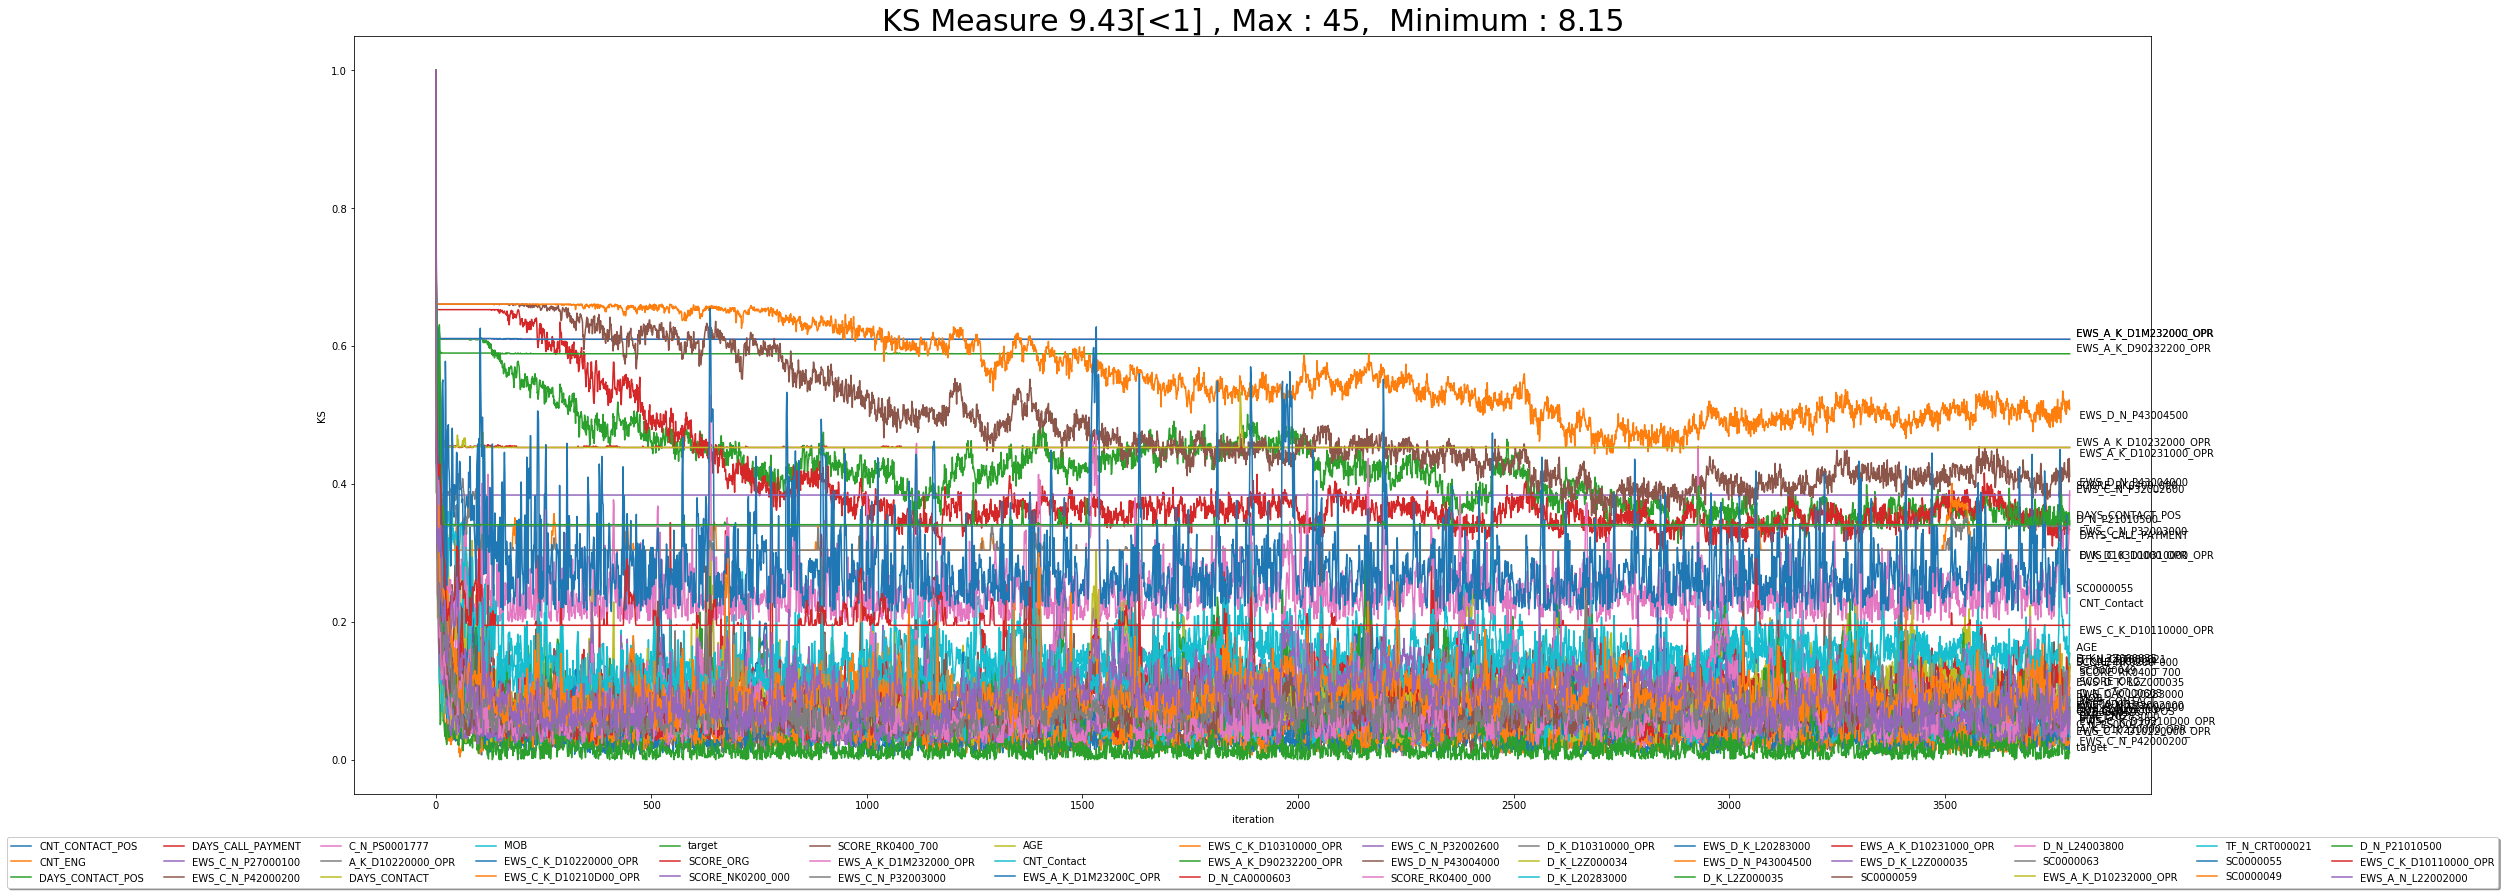

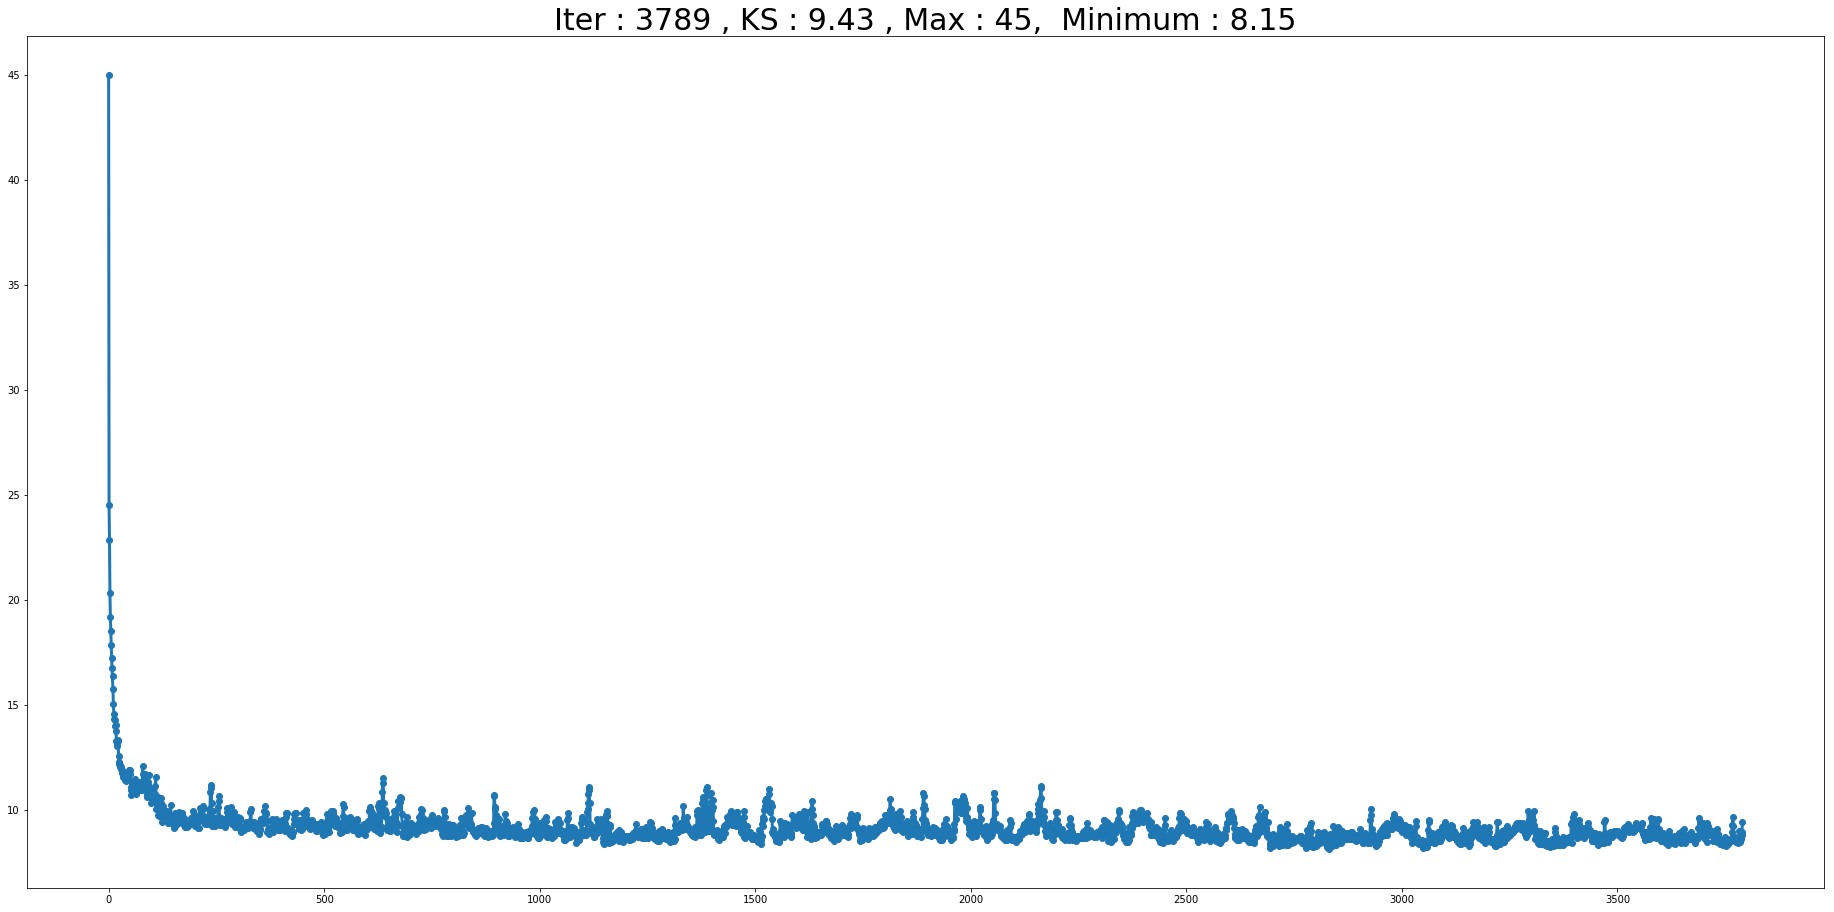

In [ ]:

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')


model_dir = "./Model_Save/{}".format(path_v)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
sess = tf.Session(config = config) # config = config
sess.run(tf.global_variables_initializer())


saver = tf.train.Saver()

i = 0
ks_output = pd.DataFrame([[0]+[1.]*len(col)], columns = ["iter"]+col)

iteration , dloss ,  gloss = 0 , 0, 0
output = pd.DataFrame({"iter" : [iteration] , "dloss" : [dloss] , "gloss" : [gloss] })
ks_init = len(col)
Total_ks_graph = pd.DataFrame({"iter":[iteration] , "ks" :[ks_init]})

Margin = 14
ROW , COL = 7,7

print("START")


for i in range(2000):
    X_mb = sample_data(data = data , n=mb_size)
    z_mb = sample_z(mb_size, z_dim)

    _, G_recon_loss_curr = sess.run([G_recon_solver, G_recon_loss], 
                                    feed_dict={X: X_mb , z: z_mb })

    if i % 500 == 0:
        print('Iter-{}; Pretrained G loss: {:.4}'.format(i, G_recon_loss_curr))



for i in range(1000000):
    X_mb = sample_data(data = data , n=mb_size)
    z_mb = sample_z(mb_size, z_dim)
    
    
    if i < 200 : 
        for _ in range(10) :
            _, dloss = sess.run(
                [D_solver, D_loss], feed_dict={X: X_mb, z: z_mb})
    else : 
        
        if (Total_KS > Total_ks_graph.ks.min()) & (Total_ks_graph.ks.min() < 9 ): 
            
            chkpt_fname = tf.train.latest_checkpoint( model_dir )
            saver.restore(sess, chkpt_fname)
            z_test_value = sample_z(m=5000 , n=z_dim)
            good_replay_v = sess.run(G_sample, feed_dict={z : z_test_value})
            
            for _ in range(3) :
                _, experience_loss = sess.run(
                    [D_solver, D_loss], feed_dict={X: good_replay_v , z: z_mb })
            
        for _ in range(10) :
            _, dloss = sess.run(
                [D_solver, D_loss], feed_dict={X: X_mb, z: z_mb})
            
    
    for _ in range(20) :
        _, gloss = sess.run(
                [G_solver, G_loss], feed_dict={X: X_mb, z: z_mb})

    
    iteration +=1
    
    D_limit , G_limit = 1.0 , 1.0
        
    dcount = 0 
    while dloss > D_limit  : 
        dcount += 1
        _, dloss = sess.run([D_solver, D_loss], feed_dict={X: X_mb, z: z_mb})
        if dcount > 2000 :
            print("{}th  Dicriminator Loss : {}".format(i, dloss) )
            break
        if dloss < D_limit : 
            print("D 탈출")
            
    gcount = 0 
    while gloss > G_limit :
        gcount += 1 
        _, gloss = sess.run([G_solver, G_loss], feed_dict={X: X_mb, z: z_mb})
        if gcount > 2000 :
            print(" {}th  Generate Loss : {}".format(i, gloss) )
            break
        
    output1 = pd.DataFrame({"iter" : [iteration] , "dloss" : [dloss] , "gloss" : [gloss] })
    output  = output.append(output1)
    
    dloss = round( np.float64(dloss),4)
    gloss = round( np.float64(gloss),4)
    
    res ="Hinge,Boundary Loss Replay Memory"
    ks_output , Total_ks_graph , Margin  , Total_KS = Check_KS(ks_output , Total_ks_graph , Margin , ROW , COL)
    
    if (i % 100 == 0) & (Margin < 10.0) :
        clear_output(wait= True)
        
        print('Iter: {}; D_loss: {:.4}; G_loss: {:.4}'
              .format(i, dloss, gloss))
        show_plot(row = ROW , ncol= COL)

    

## 실시간 KS 그림을 찍으면서 기준 KS를 통과하면 저장하는 방식으로 진행
### 학습이 안되는건지 내가 너무 조급한건지?
### DLOSS : WGan-gp Gloss : boundary seek gan  학습을 오래 해야 결로인 날 듯